In [ ]:
#Remember to restart runtime after installation
!pip install scvi-tools --quiet
!pip install pynndescent --quiet
!pip install scanpy --quiet
!pip install leidenalg --quiet
!pip install pygments==2.14.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.6/72.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import anndata
import scvi
import scanpy as sc
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import warnings

# Define directory locations (Change according to folder structure preferred)
mainDir = r"drive/MyDrive/Isaac_Ang_Shared_Folder/" #change this line to your folder structure
dataDir = ''.join([mainDir, 'data/'])
rawDir = ''.join([dataDir, 'raw/'])
processedDir = ''.join([dataDir, 'processed/'])

# Set settings
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 1
sc.set_figure_params(figsize=(6,6), frameon=False)
sc.settings.n_jobs=2
sc.settings.figdir = ''.join([mainDir, 'figures/'])

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [ ]:
#%% Load data
tabula_file = ''.join([rawDir, 'TS_Blood_log1p_unscaled_10X.h5ad'])
tabula = sc.read_h5ad(tabula_file)

#Filter cells
sc.pp.filter_cells(tabula, min_genes = 10) 

In [ ]:
tabula

AnnData object with n_obs × n_vars = 37422 × 400
    obs: 'tissue_in_publication', 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'ethnicity', 'development_stage', 'cell_type_cons', 'cell_type_cons_f'
    var: 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_biotype', 'feature_is_filtered', 'feature_name', 'feature_reference', 'isglyco'
    uns: 'X_normalization', '_scvi', '_training_mode', 'default_embedding', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_pre

In [ ]:
scvi.model.SCVI.setup_anndata( # no batch specified
  tabula, layer = "decontXcounts"
)

In [ ]:
def run_scvi(
    tabula,
    n_latent=50,
    n_layers=3,
    dropout_rate=0.1,
    dispersion="gene",
    max_epochs=100,
    batch_size=1024,
    obsm_latent_key="X_scvi",
):
  model = scvi.model.SCVI(
      tabula,
      n_latent=n_latent,
      n_layers=n_layers,
      dropout_rate=dropout_rate,
      dispersion=dispersion,
      use_layer_norm="both",
      use_batch_norm="none", 
      encode_covariates=True,
  )

  model.train(max_epochs=100, train_size=1.0, batch_size=batch_size)
  tabula.obsm[obsm_latent_key] = model.get_latent_representation(tabula)

In [ ]:
#Change Runtime type to GPU for faster convergence
run_scvi(
    tabula,
    max_epochs = None, # calculates based off # cells
    n_latent = 50,
    dropout_rate = 0.1,
    dispersion = "gene-batch", # splits by batch if batch_key in setup_anndata exists
    obsm_latent_key = 'X_scvi', # store results in a new column called X_scvi
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [00:57<00:00,  1.83it/s, loss=121, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:57<00:00,  1.75it/s, loss=121, v_num=1]


In [ ]:
sc.pp.neighbors(tabula, use_rep='X_scvi', method='umap', n_neighbors=15) # get connectivities between data points
sc.tl.umap(tabula)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


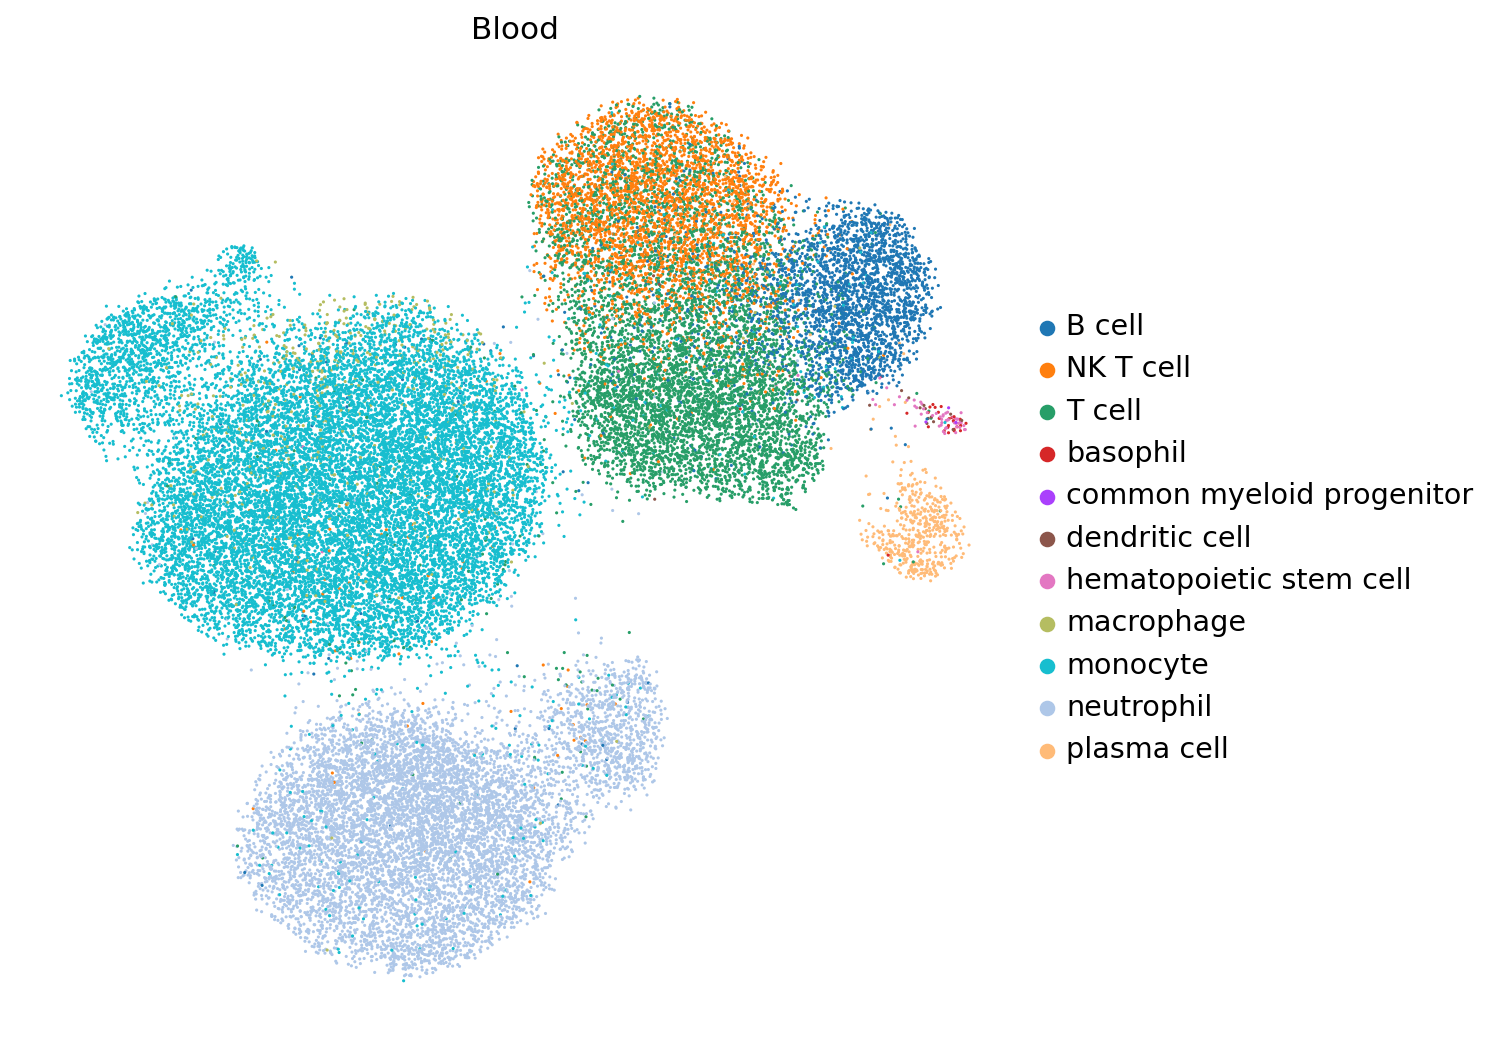

In [ ]:
with rc_context({'figure.figsize': (8, 8)}):
  sc.pl.umap(tabula, color="cell_type_cons_f", size=8, title = "Blood", save="_blood_10x.png")

In [ ]:
tabula.write_h5ad(''.join([processedDir, 'paper/TS_scvi_blood_glyco.h5ad']))